# Premise  
The main idea is to learn from human-assigned listing prices how to predict a rental price for a property, given some parameters about it. The hidden hypothesis is that the existing pricings which will be used, are rational. To ensure that, some quality criteria will be imposed on the data that will be used by the model.  
The first of these criteria has to do with the age of the entry, more like its last update, and it is hinted by the last review the entry got. If it is more than 1 year ago the listing price is probably outdated and out of sync with the current market and at worst not available for rent anymore. These listings can "confuse" the ML algorithm. Indeed,after testing, the r^2 without the outdated data was much better. A similar approach was taken for the never-rented entries which were more than 2 months old, as they are not market mature.  
The 2nd quality criterion was bad reviews rating (<70). After testing, this too had a positive effect.  
A lot of trial-and-error and fine-tuning were used and in the end Gradient Boosting performed best out of the regressors
(linear Regression, which is included for completion and Random forest,  whch is not, and performed worst out of the three) that I tried.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#will be used for price and extra_people
def turntonum(tobeturned,ctobestripped="",ctobereplaced="",cnew=""):
    #takes the list tobturned strips it from ctobestripped and makes the replacemets and int   
    tobeturned=[x.strip(ctobestripped)for x in tobeturned]
    tobeturned=pd.to_numeric(pd.Series(tobeturned).apply(lambda x: x.replace(ctobereplaced,cnew)))
    return tobeturned

def dummify(df,tobedummy):
    m = pd.get_dummies(tobedummy)
    df = pd.concat([df, m], axis=1)
    return df

In [2]:
listings=pd.read_csv ("listings.csv")
listings.drop_duplicates(subset=["id"], inplace=True)

In [3]:
#quality criteria of the listings I will use.
#price cannot be 0
listings.drop(listings[listings.price == "0"].index, inplace=True)

#invalid
listings.drop(listings[listings.accommodates <= 0].index, inplace=True)

#Only market tested data will be used 
listings.drop(listings[listings.review_scores_rating <= 70].index, inplace=True)

#throw away data without reviews and last calendar update older than 2 months, as useless
listings.drop(listings[listings.first_review.isna()& ~listings["calendar_updated"].str.contains("day|week|month ago")].index,\
              inplace=True)

#throw away old data (last review > than 1 years old)
listings.drop(listings[listings.last_review < "2017-08-07"].index, inplace=True)

#the following upped r2 from 0.51 to 0.54
#deletes 18 values
listings.drop(listings[(listings.cancellation_policy == "super_strict_30") | (listings.cancellation_policy == "super_strict_60")].\
              index, inplace=True)
#------------------------------------------------------------

#--------------------------------------------------------------
listings = listings.reset_index(drop=True)


In [4]:

listings.extra_people=turntonum(listings.extra_people,"$",",","")
listings.price=turntonum(listings.price,"$",",","")


#if the next don't exist they are 0
#and then they are turned to num
listings["security_deposit"].fillna("0", inplace=True)
listings.security_deposit=turntonum(listings.security_deposit,"$",",","")

listings["cleaning_fee"].fillna("0", inplace=True)
listings.cleaning_fee=turntonum(listings.cleaning_fee,"$",",","")

#guests included cannot be more than the accomodated.
#if the extra people price is 0, then guests included are the maximum of people accomodated

listings['guests_included'] = np.where((listings['extra_people'] == 0)\
                             ,listings['accommodates'], listings['guests_included'])

listings['guests_included'] = np.where((listings['guests_included'] > listings["accommodates"])\
                             ,listings['accommodates'], listings['guests_included'])

#fill na with 0 
listings["bathrooms"].fillna(0, inplace=True)
listings["bedrooms"].fillna(0, inplace=True)
listings["beds"].fillna(0, inplace=True)
listings["reviews_per_month"].fillna(0, inplace=True)
#listings["summary"].fillna("", inplace=True)
#listings["name"].fillna("", inplace=True)

In [5]:
#everybody pays for cleaning.Some just charge for it.
listings["real_price"]=listings["price"]+listings["cleaning_fee"]/listings["minimum_nights"]

#listings["max_price"]=(listings["accommodates"]-listings["guests_included"])*listings["extra_people"]+listings["real_price"]
#people give price according to accommodated not the minimum included.
#chose not to go with the above


listings["price_per_guest"]=listings["real_price"]/listings["guests_included"]

In [6]:
descriptions=listings[["name","summary",'space','description','neighborhood_overview','notes','transit',\
                  'access','interaction','house_rules','amenities']]


listings=listings[['neighbourhood_cleansed',\
                  'is_location_exact','property_type',\
                  'room_type','accommodates','bathrooms','bedrooms','beds','bed_type',\
                  'price','security_deposit','cleaning_fee',\
                  'guests_included','last_review',\
                  'number_of_reviews',"minimum_nights","extra_people",\
                  'instant_bookable','cancellation_policy',\
                  'reviews_per_month',"review_scores_rating",\
                  "real_price","price_per_guest"]]
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15243 entries, 0 to 15242
Data columns (total 23 columns):
neighbourhood_cleansed    15243 non-null object
is_location_exact         15243 non-null object
property_type             15243 non-null object
room_type                 15243 non-null object
accommodates              15243 non-null int64
bathrooms                 15243 non-null float64
bedrooms                  15243 non-null float64
beds                      15243 non-null float64
bed_type                  15243 non-null object
price                     15243 non-null float64
security_deposit          15243 non-null float64
cleaning_fee              15243 non-null float64
guests_included           15243 non-null int64
last_review               14067 non-null object
number_of_reviews         15243 non-null int64
minimum_nights            15243 non-null int64
extra_people              15243 non-null float64
instant_bookable          15243 non-null object
cancellation_policy     

In [7]:
listings['expected_by_neigh'] = listings["guests_included"]*listings["price_per_guest"].groupby(listings['neighbourhood_cleansed']).transform('mean')

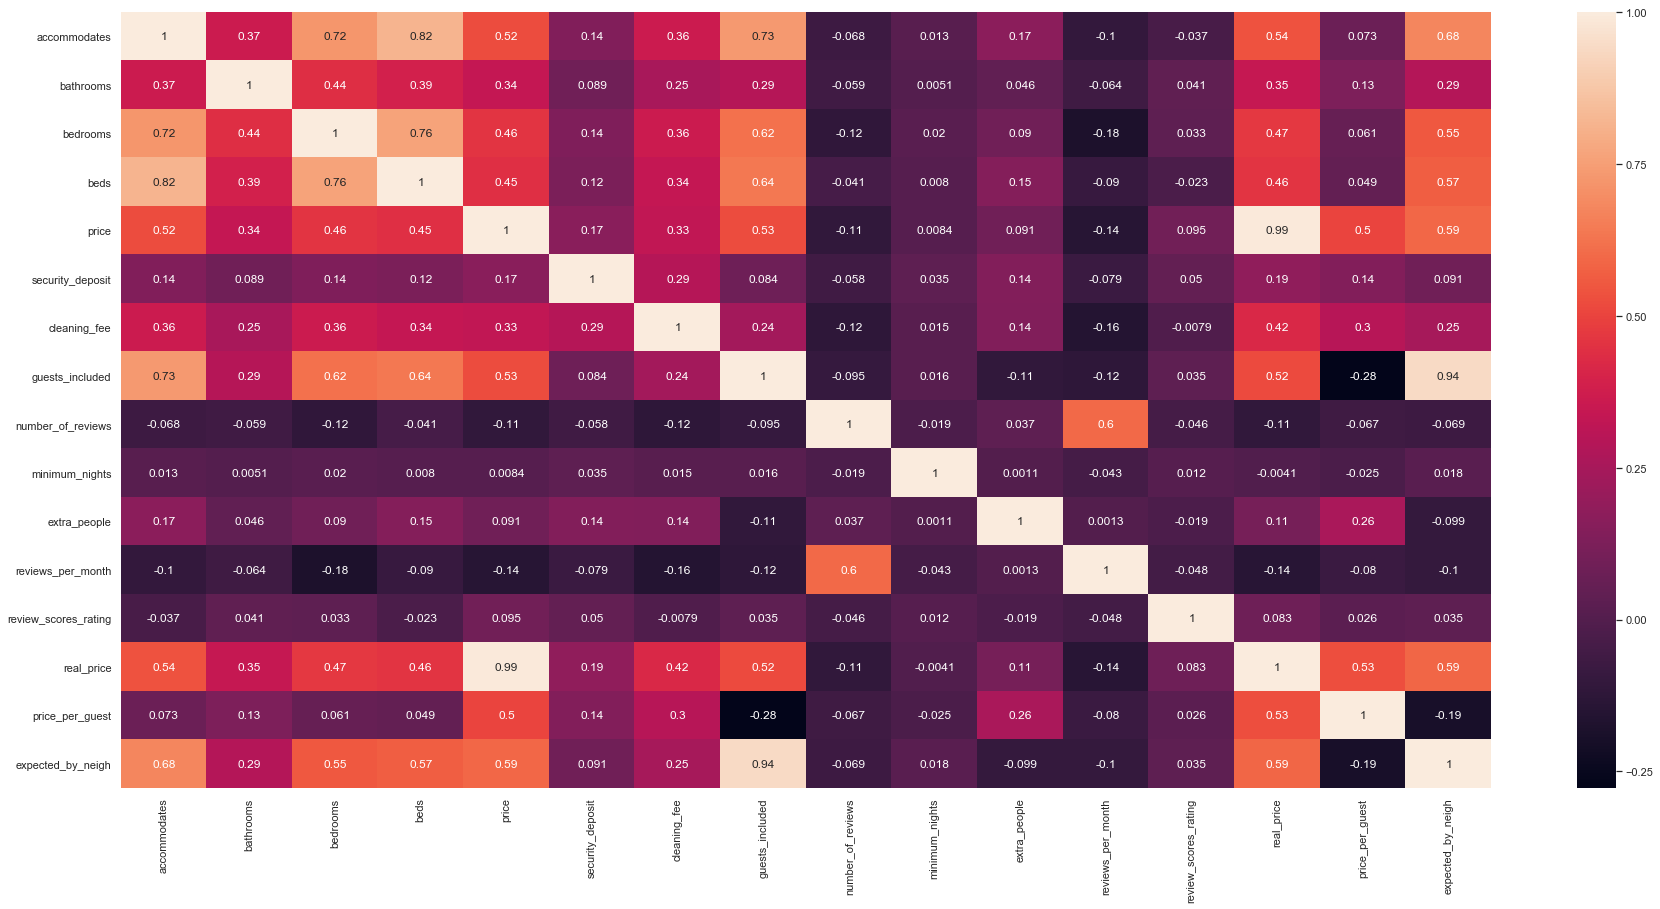

In [8]:
corr_matrix = listings.corr()
sns.set(rc={'figure.figsize':(30.7,14.27)})
hel=sns.heatmap(data=corr_matrix, annot=True)
fig2=hel.get_figure()
fig2.savefig('heatmap.png')

In [9]:
corr_matrix["real_price"].round(2).sort_values(ascending=False)

real_price              1.00
price                   0.99
expected_by_neigh       0.59
accommodates            0.54
price_per_guest         0.53
guests_included         0.52
bedrooms                0.47
beds                    0.46
cleaning_fee            0.42
bathrooms               0.35
security_deposit        0.19
extra_people            0.11
review_scores_rating    0.08
minimum_nights         -0.00
number_of_reviews      -0.11
reviews_per_month      -0.14
Name: real_price, dtype: float64

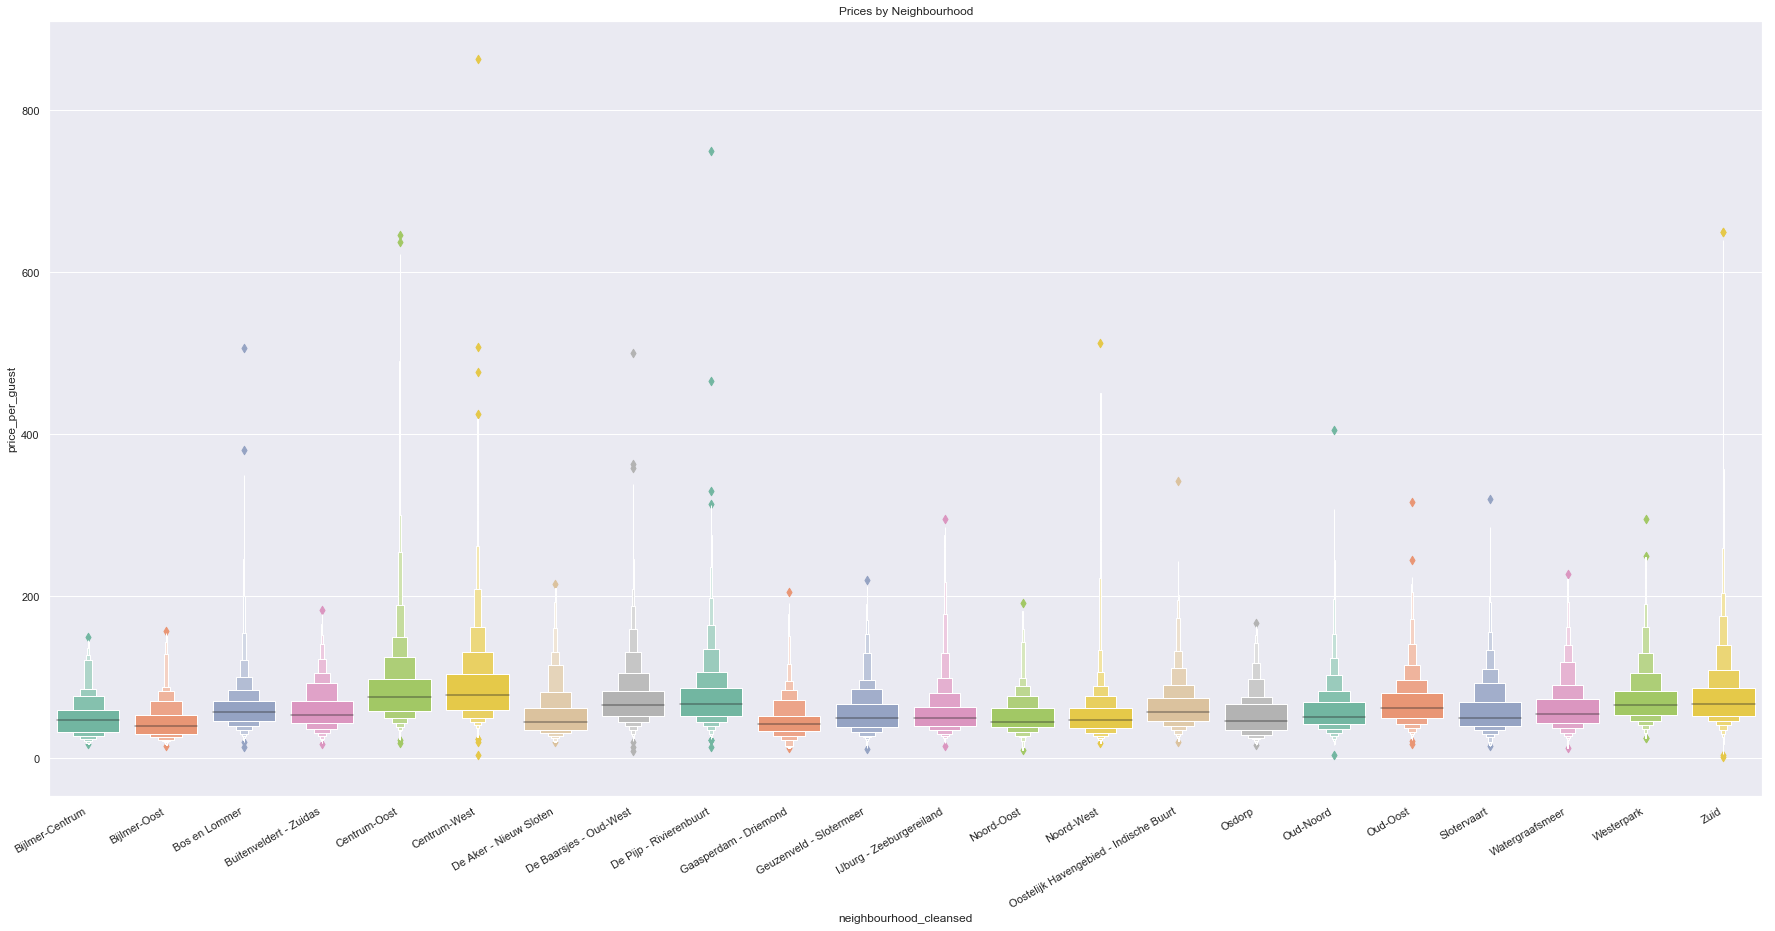

In [10]:
my_order = listings.groupby(["neighbourhood_cleansed"],sort = True)["price_per_guest"].mean().iloc[::-1].index

boom = sns.boxenplot(x="neighbourhood_cleansed", y="price_per_guest",\
                   data=listings, palette="Set2",outlier_prop=0.01,order=sorted(my_order))
boom.set_xticklabels(boom.get_xticklabels(), rotation=30, ha="right")
boom.set_title("Prices by Neighbourhood")
fig = boom.get_figure()
fig.savefig('Prices by Neighbourhood.png') 

Categorical Variables were tested either with the count-mean aggregates or with plots,similar to the one above.

In [11]:


listings.groupby('cancellation_policy').agg({'cancellation_policy':'size', 'real_price':'mean'})\
.rename(columns={'cancellation_policy':'size','real_price':'mean real_price'})



,size,mean real_price
cancellation_policy,,
flexible,3000,151.277844
moderate,5784,153.612151
strict_14_with_grace_period,6459,178.136331


In [12]:
listings.groupby('room_type').agg({'room_type':'size', 'real_price':'mean'})\
.rename(columns={'room_type':'size','real_price':'mean real_price'})

,size,mean real_price
room_type,,
Entire home/apt,11953,178.448828
Private room,3244,109.458776
Shared room,46,104.905797


In [13]:
listings.groupby('bed_type').agg({'bed_type':'size', 'real_price':'mean'})\
.rename(columns={'bed_type':'size','real_price':'mean real_price'})
#bed_type will not be used due to it s one sided distribution

,size,mean real_price
bed_type,,
Airbed,9,131.129630
Couch,4,106.625000
Futon,31,109.582719
Pull-out Sofa,118,103.922619
Real Bed,15081,164.156367


**Variables**

The Variables that will be used are   
**accommodates(0.54)**, this like the square feet of selling a house. Apparently, reneters choose a price according to the maximum number of guests that can fit in a house.  
**bedrooms(0.47) and beds (0.46)** which are related (0.73) but still not so close as to not use,   
**bathrooms (0.35)**,   
**expected_by_neigh (0.59)** which is an expression of the categorical variable cleansed_neighbourhood, **contains** the guests_included variable (0.49) and essentially is what someone would expect to pay for a certain number of guests in a certain neighbourhood,  
**reviews (-0.14)** and **number_of_reviews (-0.11)** per month which are negatively related with the price and the intuitive explanation for both is that the more reviews per month and in general a room has, the cheaper the price is because more people rent it.  
The 2 categorical variables used are the ones having the strongest effect on the real_price, as seen above. 
Other categoricals were also tried but were found to be unimportant.


In [14]:
#the final array to be used for the pricing model
x=listings[['real_price','bedrooms',"bathrooms","room_type","accommodates","number_of_reviews",\
            'beds','expected_by_neigh','reviews_per_month',"cancellation_policy"]]

#from categorical to pseudonumerical
x=dummify(x,x.room_type)
x=dummify(x,x.cancellation_policy)

drops = ["cancellation_policy","room_type"]
#         "room_type","bed_type"]
x.drop(drops, inplace=True, axis=1)



#regression to the logarithm of real_price has much better resullts
y=np.log(x["real_price"])
x=x.drop(["real_price"],axis=1)

In [15]:
from sklearn.model_selection  import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

#--------------------------------gradient boosting-------------------------------------
from sklearn import ensemble

clf = ensemble.GradientBoostingRegressor(n_estimators =100, max_depth = 7,
          learning_rate = 0.05, loss = 'ls')
clf.fit(x_train, y_train)
#clfpred = clf.predict(x_test)
#r2_score(y_test,clfpred)

clf.score(x_test,y_test)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.5621885760055522

In [16]:
#linear regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train,y_train)
#lmpred = lm.predict(x_test)
#r2_score(y_test,lmpred)
lm.score(x_test,y_test).round(2)

0.5

**Central is GOOD**

In the next notepads we get the proof of what we ,already suspected: Centrally located places are the most wanted and as such this feature  is advertised extensively: walking distance, minutes walk, city center (and centre), around corner.. All lead to this conclusion.
Apart from the central location-related we also get many mentions of "fully equipped" something that has come to be expected from airBnB properties and is actually one of its Unique Selling Points.
Stopwords was used to cut useless words and info that we already know from other fields. Appartment from type, Amsterdam from City.

There are 593783 words in the combination of all review.


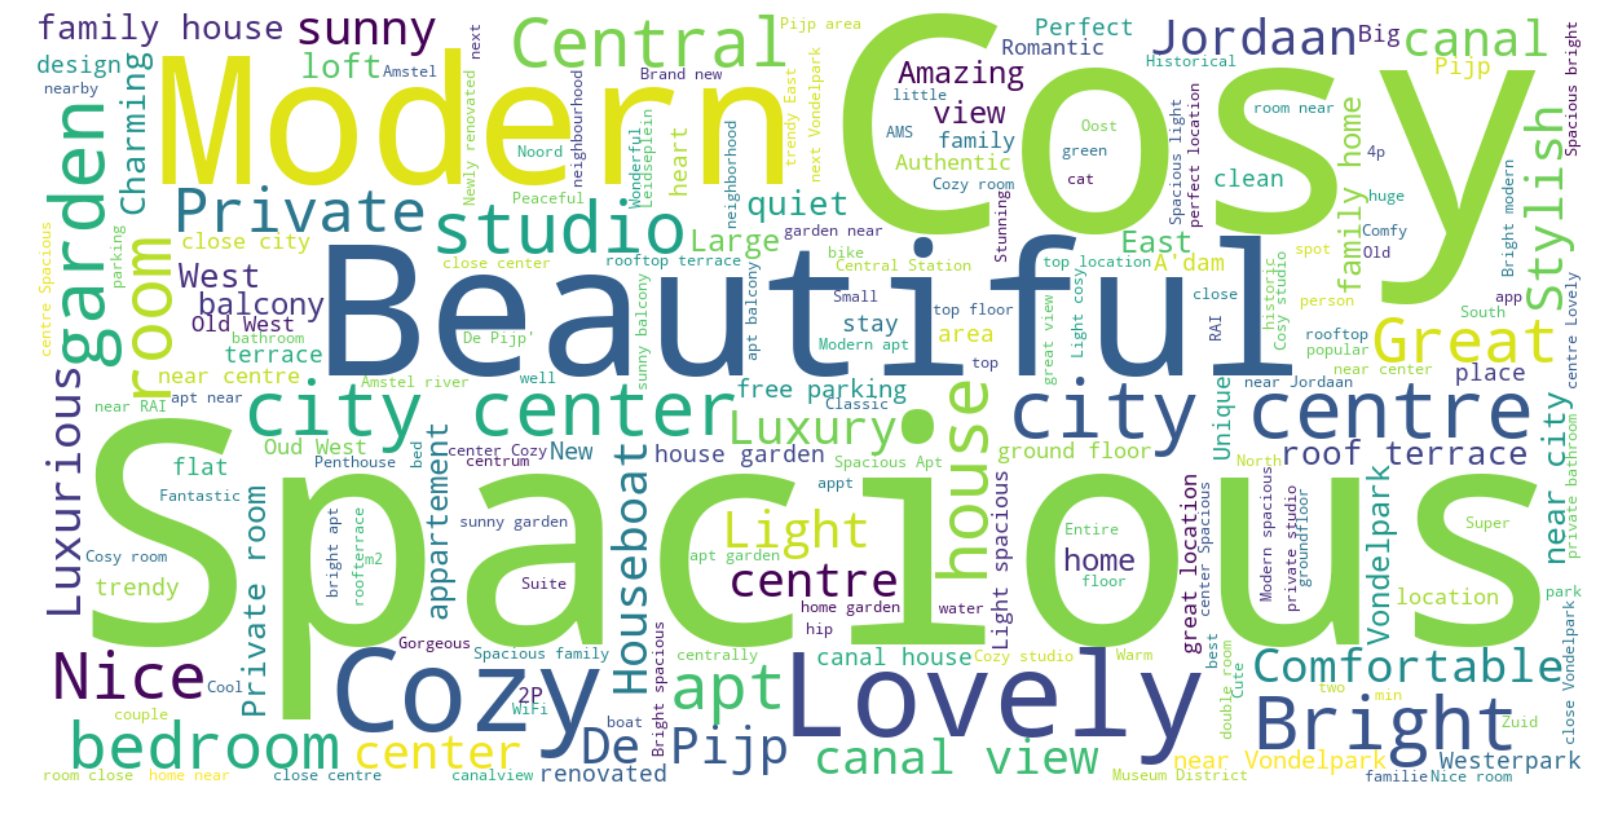

In [17]:
#------------------------------------------NAME wordcloud-------------------------------
#lets s check the most common words in the name field
text = " ".join(field for field in descriptions.name.fillna(""))
print ("There are {} words in the combination of all review.".format(len(text)))

stopwords = set(STOPWORDS)
stopwords.update(["located", "Amsterdam", "apartment", "appartment"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,height=600,width=1200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("names wordcloud.png")

There are 5734792 words in the combination of all review.


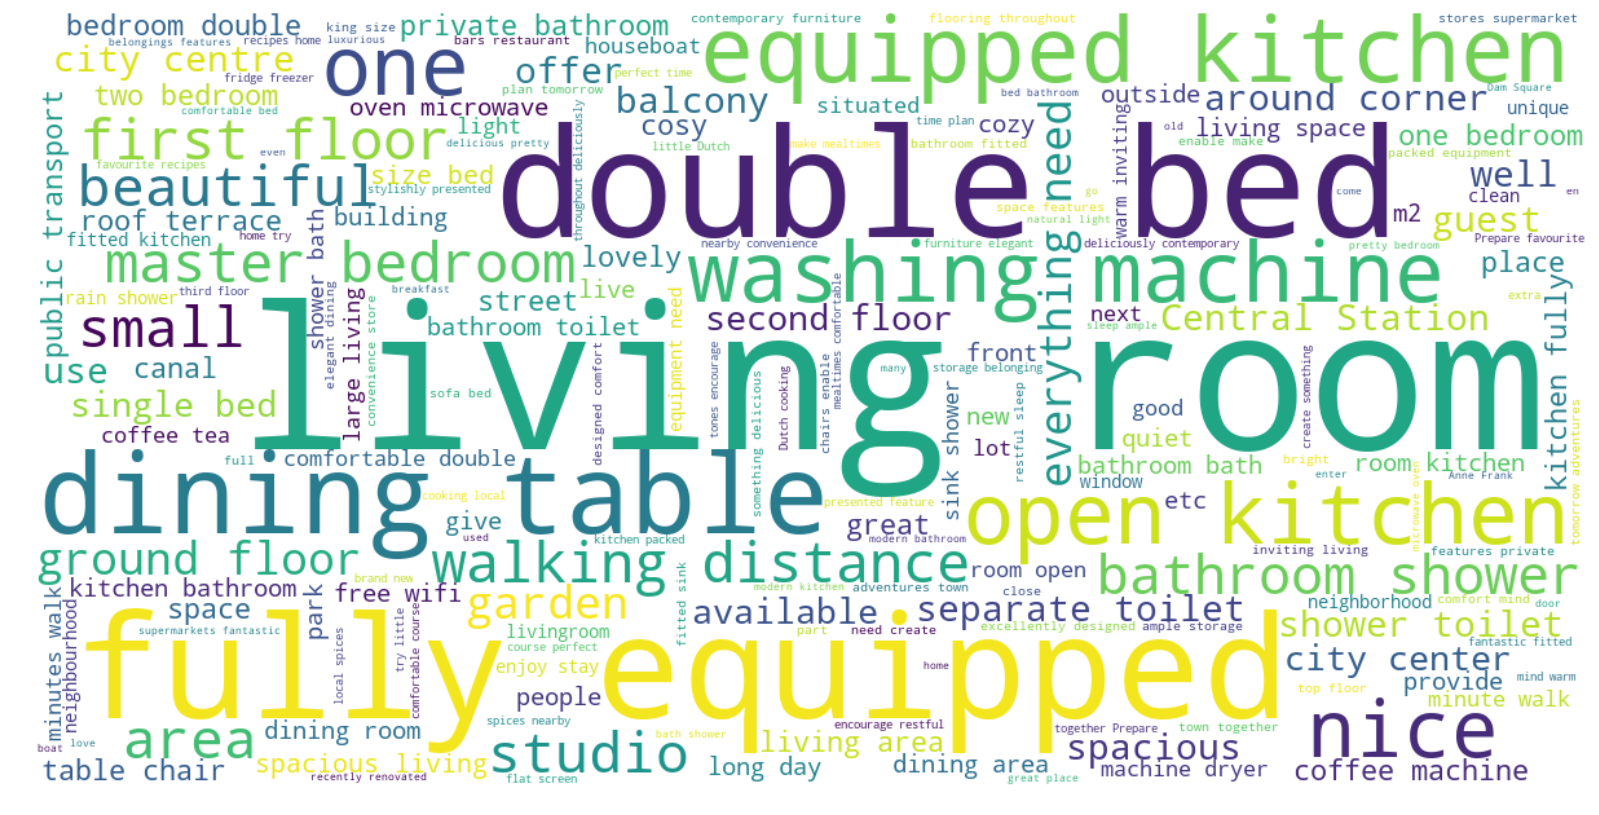

In [18]:
#-----------------------------------------SPACE desciption Wordcloud------------------------------------------------------
text = " ".join(field for field in descriptions.space.fillna(""))
print ("There are {} words in the combination of all review.".format(len(text)))


stopwords = set(STOPWORDS)
stopwords.update(["located", "Amsterdam", "apartment", "appartment", "will","find","house"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,height=600,width=1200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("space_wordcloud.png")


In [ ]:
#----------------------------------------- desciption field------------------------------------------------------
text = " ".join(field for field in descriptions.description.fillna(""))
print ("There are {} words total in this review.".format(len(text)))


stopwords = set(STOPWORDS)
stopwords.update(["located", "Amsterdam", "apartment", "appartment", "house", "will","find","living"])
#living room and appartments were quite prominent but offered no real info. We know that 80% of our data is appartments that 
# usually feature a living room
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,height=600,width=1200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("description wordcloud.png")

There are 12526113 words total in this review.


In cleansed neighbourhood the essence of what was described earlieris captured. Neighbourhood-wise the most desired attribute for a tourist is to be centrally located, within **walking distance**, close to places of interest: Anne Frank House , Van gogh museum, bars, restaurants.

In [ ]:
#------------------------------------------------'neighborhood_overview'-----------------------------------------

text = " ".join(field for field in descriptions.neighborhood_overview.fillna(""))
print ("There are {} words in the combination of all review.".format(len(text)))


stopwords = set(STOPWORDS)
stopwords.update(["located", "Amsterdam", "apartment", "appartment", "house","Smoke", "detector","friendly",\
                  "will","find"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,height=600,width=1200, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("neighborhood wordcloud.png")